### This notebook is my attempt at understanding how well spectrogram based call segmentation recovers acoustic features such as received levels, duration, frequency ranges etc. As I'm planning to use call segmentation from the spectrogram to separate and label individual calls that may be overlapping in time and frequency - this is a very important question to ask before I rush into using this for all of my call quantificaitons. 

In [61]:
import cv2
import numpy as np
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.filters  import sobel
from skimage import measure
from skimage.morphology import skeletonize, convex_hull_image, watershed
from skimage.filters import threshold_otsu, threshold_local
from skimage import data, img_as_float
from skimage.segmentation import chan_vese
from skimage import feature
from skimage.segmentation import random_walker
import scipy.signal as signal 
import scipy.io.wavfile as wav
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000
from make_training_data import generate_a_samplesound, rms

I'm going to make some simple chirps with known dBrms, duration and frequency ranges, and then compare these with the kind of information I get from the spectrogram call segmentation routines. 

In [143]:
# make N calls with slightly different properties and combine them all into one 
N = 100
durations = np.linspace(0.001, 0.006, N)
start_freqs = np.linspace(90000, 70000, N)
end_freqs = np.linspace(40000, 20000, N)
snr = np.tile(50, N)

all_calls = []
for durn, start_f, end_f, one_snr in zip(durations, start_freqs, end_freqs, snr):
    thiscall_dict = {}
    thiscall_dict['duration'] = durn
    thiscall_dict['freqs'] = (start_f, end_f)
    thiscall_dict['snr'] = one_snr
    thiscall_dict['sound'] = generate_a_samplesound(durn, freqs=[start_f, end_f], SNR=one_snr)
    thiscall_dict['dBrms'] = 20*np.log10(rms(thiscall_dict['sound']))
    f , t, S = signal.spectrogram(np.copy(thiscall_dict['sound']), fs=192000, nperseg=16, noverlap=0,
                                mode='complex',scaling='none', window = ('tukey', 0.05))
    thiscall_dict['specgram'] = np.flipud(S)
    all_calls.append(thiscall_dict)
    
    
    

In [144]:
%matplotlib notebook

<IPython.core.display.Javascript object>


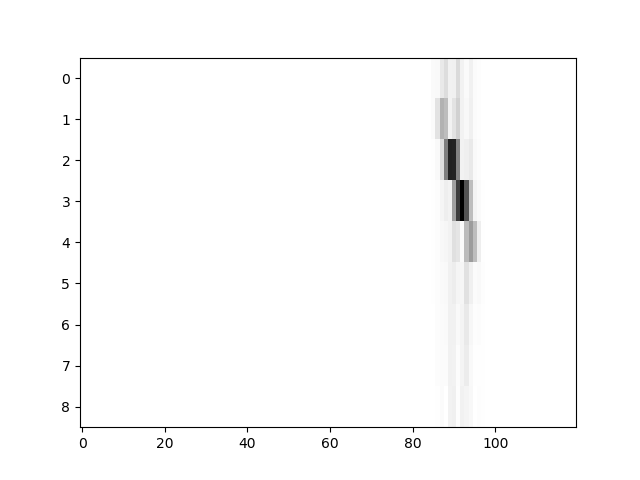

In [145]:
call_ind = 2

# begin segmentation:
eg_call_specgm = all_calls[call_ind]['specgram']
eg_call = np.abs(eg_call_specgm)
plt.figure()
plt.imshow(eg_call, aspect='auto', cmap='Greys')

<IPython.core.display.Javascript object>


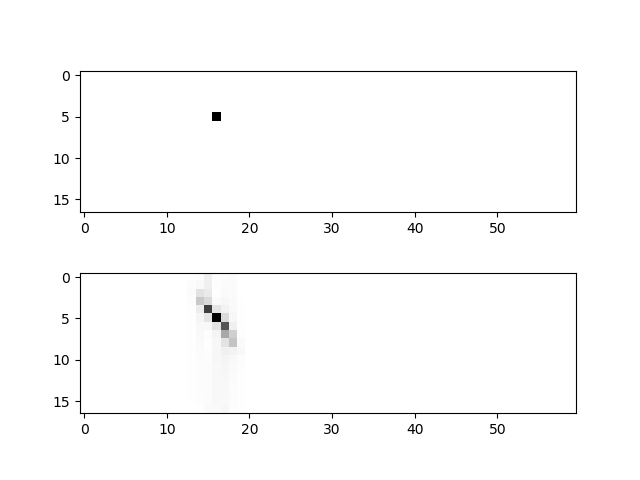

In [139]:
distance = ndimage.distance_transform_edt(eg_call)
local_maxi = peak_local_max(
    egcall_norm, indices=False, footprint=np.ones((3,3)), labels=eg_call)

plt.figure()
plt.subplot(211)
plt.imshow(local_maxi, cmap='Greys')
plt.subplot(212)
plt.imshow(eg_call, cmap='Greys')

Let's initiate the local thresholding algorithm:

<IPython.core.display.Javascript object>


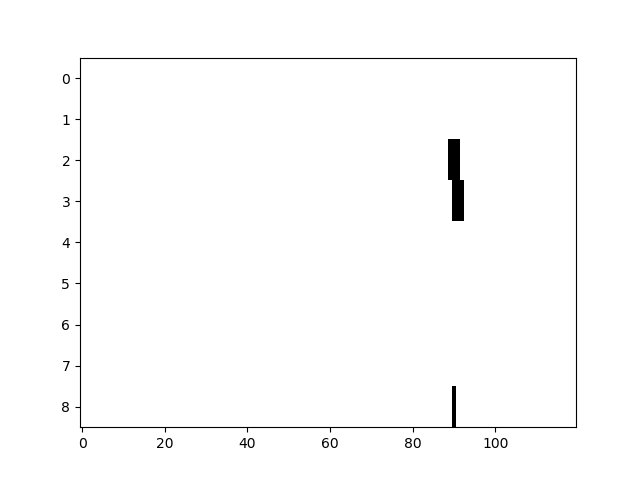

In [174]:
# scale it all
column_scale = lambda X : X/X.sum()**2
egcall_scale = np.copy(eg_call)
egcall_scale = np.apply_along_axis(column_scale, 0, egcall_scale)

local_thresh = threshold_local(egcall_scale, 11,method='gaussian')

thresh_specgm = np.zeros(eg_call.shape)
thresh_specgm[eg_call>=local_thresh] = 1
thresh_specgm = np.uint8(thresh_specgm)
plt.figure()
plt.imshow(thresh_specgm, aspect='auto', cmap='Greys')

Le'ts also try out the Chan-Vese segmentation method : 

In [175]:
cv = chan_vese(eg_call/np.max(eg_call), mu=0.01, lambda1=1, lambda2=1, tol=1e-3, max_iter=2000,
               dt=0.5, init_level_set="checkerboard", extended_output=True)

In [176]:
egcall_norm = eg_call/np.max(eg_call)

<IPython.core.display.Javascript object>


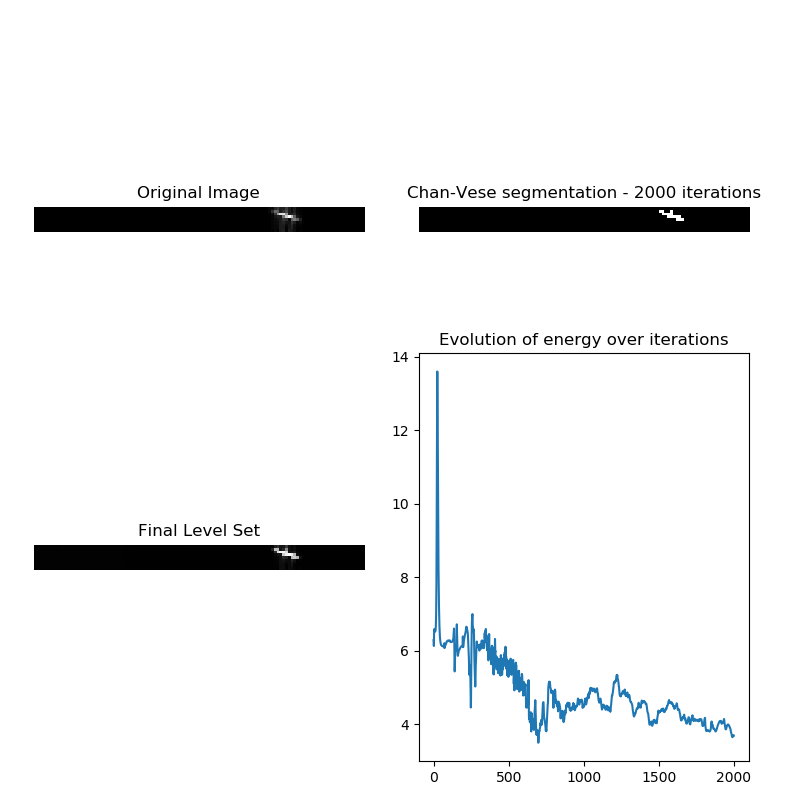

In [177]:

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(eg_call, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv[0], cmap="gray")
ax[1].set_axis_off()
title = "Chan-Vese segmentation - {} iterations".format(len(cv[2]))
ax[1].set_title(title, fontsize=12)

ax[2].imshow(cv[1], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)

ax[3].plot(cv[2])
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()

In [184]:
# having done this, let's now get the contours 
contours = measure.find_contours(np.invert(cv[0]), 0.5, fully_connected='high')

<IPython.core.display.Javascript object>


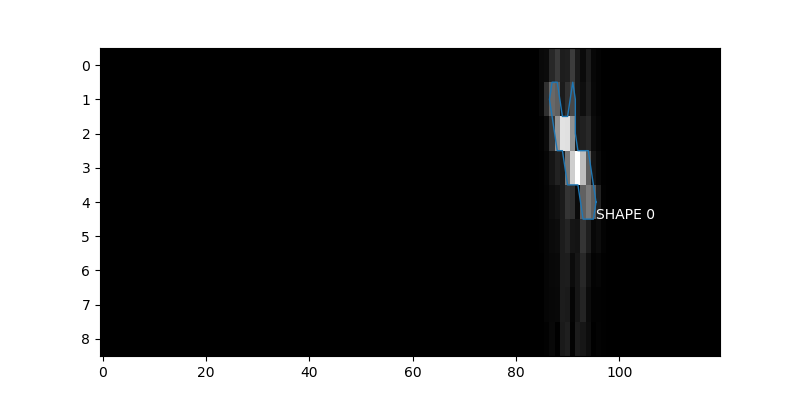

In [185]:
plt.figure(figsize=(8,4))
plt.imshow(egcall_norm, aspect='auto', interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1)
    plt.text(np.max(contour[:, 1]), np.max(contour[:, 0]), 'SHAPE '+str(n), color='white')
plt.show()

Let's extract the larget call in this area and then begin to check out the properties : 

In [169]:
shape_num = 0
call_cont = contours[shape_num]

In [170]:
rev_f = f[::-1]

### How well does the outline method pick up the terminal frequencies of the calls ? 
In principle, the minimum and maximum y-coordinates should give the start/end frequencies as defined by the FFT resolution. Given that we have a 64 window FFT, one can expect the frequency resolution may not be *that* great ...eg. for a 64 window FFT one expects ~ 3 kHz resolution -- which is okay or horrible...depending on what is really required...

In [171]:
# now let's add the total energy over all the bands in this polygon : 
max_freq, min_freq = rev_f[int(np.min(call_cont[:,0]))], rev_f[int(np.max(call_cont[:,0]))]
max_freq, min_freq, all_calls[call_ind]['freqs']

(84000.0, 60000.0, (89595.95959595959, 39595.9595959596))

#### The terminal frequency identification is not *too* great, and it can be pretty off in some cases...hmm, wondering how to overcome this problem. 

In [42]:
min_to_max_X = np.int16(np.arange(np.min(call_cont[:,1]), np.max(call_cont[:,1])+1))
min_to_max_X

array([0, 1, 2, 3, 4, 5], dtype=int16)

And now, take out the outline section in the original spectrogram to then calculate the total energy in there : 

In [43]:
section = eg_call[:, min_to_max_X] 

<IPython.core.display.Javascript object>


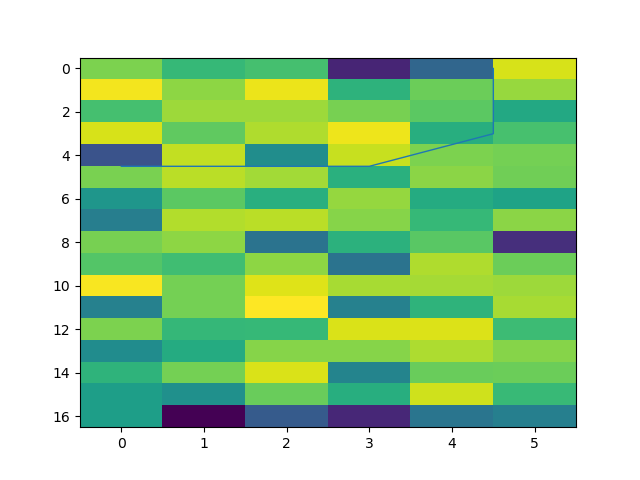

In [44]:
plt.figure()
plt.imshow(20*np.log10(section+10**-6), aspect='auto')
plt.plot(call_cont[:, 1]- min_to_max_X[0], call_cont[:, 0], linewidth=1)

## How accurately does the outline method capture the duration of the call ? 

In [16]:
start_ind , end_ind = np.min(call_cont[:, 1]), np.max(call_cont[:,1])
duration_inds = end_ind - start_ind 
duration_s = duration_inds*(64/192000.0)
print duration_s, all_calls[call_ind]['duration']

0.0006666666666666666 0.0022626262626262625


#### The method works ...*very* okay-ish, but gives an estimate of +/- 1 ms accuracy, which is not so great for the short calls perhaps - but maybe it could be improved by better segmentation?

## How accurately does the outline method capture the intensity of the call in dBrms ? 
Normally rms (and dB rms) is calculated by taking the waveform of the whole signal. However, here in the spectrogram representation, only the FFT is available. Thanks to Parseval's theorem, it should be possible to go back and forth between the FFT coefficients and the rms of a signal. I'm hoping it works out fine here. 

Parseval's theorem essentially states that the sum-square of the signal is equal to the mean sum square of a DFT's coefficients. I had to go back and modify the signal.spectrogram function a bit because it only gave  *scaled* DFT coefficients - scaled to the *whole* spectrogram ...which is NOT what I need for this purpose. 

In [17]:
all_calls[call_ind].keys()

['sound', 'specgram', 'freqs', 'snr', 'duration', 'dBrms']

In [18]:
# calculate the start and stop indices for the outlined area
timestep = 64/192000.0
callstart_ind = int(min_to_max_X[0]*64)
callend_ind = int((min_to_max_X[-1]+1)*64)

In [19]:
rms_sound = rms(all_calls[call_ind]['sound'][callstart_ind:callend_ind])


In [20]:
# take the sum of the signal, specifically around the time where the chirp is.. : 
calc_meansumsq_coeffs = lambda X, fftsize : np.sum(np.abs(X)**2.0)/float(fftsize**2.0)
# calculate DFT mean squared coefficients 
call_chunks = [all_calls[call_ind]['sound'][chunk_startind*64:(chunk_startind+1)*64] for chunk_startind in min_to_max_X]
fft_callchunks = map(np.fft.fft, call_chunks)

# do both the chunk calculations : 
meansq_chunks = [calc_meansumsq_coeffs(each_fftchunk, 64) for each_fftchunk in fft_callchunks]
rms_spec = np.array(map(np.sqrt, meansq_chunks))
rms_chunks = np.array(map(rms, call_chunks))
wholerms_fromchunks = rms(rms_chunks)

# now try and combine the two sources ... 
var_chunks = map(lambda X : X**2.0, rms_chunks)

print(rms_sound, wholerms_fromchunks)
print(20*np.log10(rms_sound), 20*np.log10(wholerms_fromchunks))

(0.0437812484066601, 0.043781248406660096)
(-27.174237176789973, -27.174237176789976)


#### The spectrogram outline method is indeed able to capture the waveform rms from the spectrogram !! 

### Now, I'd like to scale up the analysis to see how well the outlining based method works.

In [21]:
all_calls[0].keys()

['sound', 'specgram', 'freqs', 'snr', 'duration', 'dBrms']

In [198]:
# normalise all the spectrogram images and get a mask of the call by thresholding : 
def calc_outline_for_a_call(each_call, use_chanvese=True):
    abs_specgm = np.abs(each_call['specgram'])
    normalised_specgm =  abs_specgm/np.max(abs_specgm)
    # normalise each FFT segment 
    
    #if not use_chanvese: 
    
        # calculate threshold values 
    #   local_thresholds = threshold_local(normalised_specgm, 15,method='gaussian')
        # get call - mask 
    #    thresh_specgm = np.zeros(normalised_specgm.shape)
    #    thresh_specgm[normalised_specgm>=local_thresholds] = 1
    #    thresh_specgm = np.uint8(thresh_specgm)    
    #    each_call['thresh_specgm'] = thresh_specgm
        # get outline 
    #    each_call['thresh_specgm'] = thresh_specgm

    #else :    
    
    cv = chan_vese(normalised_specgm, mu=0.01, lambda1=1, lambda2=1, tol=1e-3, max_iter=2000,
               dt=0.5, init_level_set="checkerboard", extended_output=True)
    thresh_specgm = np.invert(cv[0])
    
    contours = measure.find_contours(thresh_specgm, 0.5, fully_connected='high')
    each_call['contour'] = contours
    return(each_call)  

    

In [199]:
# thanks  https://stackabuse.com/parallel-processing-in-python/ 
from multiprocessing import Pool
pool = Pool(processes=4)


In [200]:
output = pool.map(calc_outline_for_a_call, all_calls, chunksize=25) 

<IPython.core.display.Javascript object>


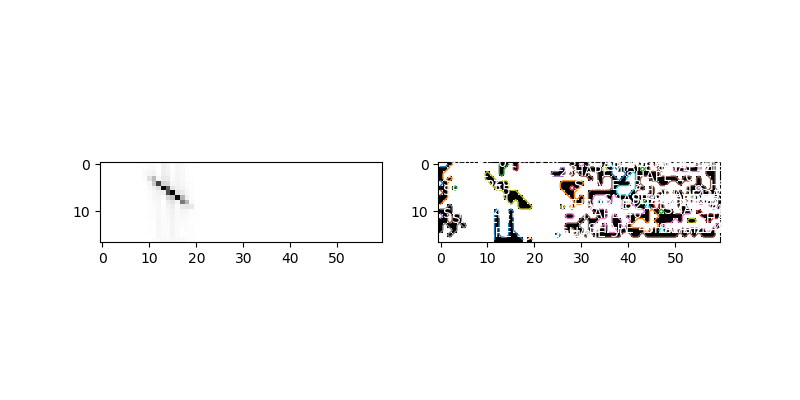

In [126]:
ind =20
one_call = output[ind]
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(np.abs(one_call['specgram']), cmap='Greys')
plt.subplot(122)
plt.imshow(one_call['thresh_specgm'], cmap='Greys')

for n, contour in enumerate(one_call['contour']):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1)
    plt.text(np.max(contour[:, 1]), np.max(contour[:, 0]), 'SHAPE '+str(n), color='white')
plt.show()


In [ ]:
a_call = output[ind].copy()
a_call = calc_outline_for_a_call(a_call)

In [ ]:
plt.figure()
plt.subplot(121)
plt.imshow(np.abs(a_call['specgram']), cmap='Greys')
plt.subplot(122)
plt.imshow(a_call['thresh_specgm'], cmap='Greys')

for n, contour in enumerate(a_call['contour']):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1)
    plt.text(np.max(contour[:, 1]), np.max(contour[:, 0]), 'SHAPE '+str(n), color='white')
plt.show()


In [ ]:
call_ind = 5
chosen_call = output[call_ind]
plt.figure(figsize=(8,4))
plt.imshow(np.abs(chosen_call['specgram']), aspect='auto', interpolation='nearest', cmap=plt.cm.gray)

some_contours = chosen_call['contour']

for n, contour in enumerate(some_contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1)
    plt.text(np.max(contour[:, 1]), np.max(contour[:, 0]), 'SHAPE '+str(n), color='white')
plt.show()